This is an excercise from Google Machine Learning crash course about validation sets. Original url is [here](https://colab.research.google.com/notebooks/mlcc/validation.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=validation-colab&hl=en)

**Learning objectives**:

* Use bultiple features, instead of a single feature to further improve the effectiveness of a model
* Debug issues in model input data
* Use a test data to check if a model is overfitting the validation data

We are going to use [California housing data set](https://developers.google.com/machine-learning/crash-course/california-housing-data-description), to try and predict `median_house_value` at the city block level from 1990 census data.

In [53]:
from __future__ import print_function

import math 

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

from tensorflow.keras import optimizers
from functools import partial


# Original Codelab code had this line, but it is not compatible with TensorFlow 2
# tf.logging.set_verbosity(tf.logging.ERROR)
# Replaced with below
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

# Line below was missing - i.e. we did not reshuffle the data.
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index)
)

In [7]:
def preprocess_features(california_housing_dataframe):
    """Prepares input features from California housing data set.
    
    Args:
        california_housing_dataframe: A Pandas DataFrame expected to contain data
          from the California housing data set.
    Returns:
        A DataFrame that contains the features to be used for the model, including 
        synthetic features.
    """
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"
        ]]
    processed_features = selected_features.copy()
    # Create synthetic feature
    processed_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"] /
        california_housing_dataframe["population"]
    )
    return processed_features

def preprocess_targets(california_housing_dataframe):
    """Prepares target features (i.e. labels) from California housing data set.
    
    Args:
        california_housing_dataframe: A Pandas DataFrame expected to contain data
            from the California housing data set.
    Returns
        A DataFrame that contains the target feature
    """
    output_targets = pd.DataFrame()
    
    # Scale the target to be in units of thousands of dollars
    output_targets["median_house_value"] = (
        california_housing_dataframe["median_house_value"] / 1000.0)
    
    return output_targets

For the **training set**, we'll choose the first 12000 examples, out of the total 17000

In [54]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.5,28.6,2637.4,537.7,1427.9,499.3,3.9,2.0
std,2.1,2.0,12.6,2179.5,419.1,1160.9,381.3,1.9,1.2
min,32.5,-124.3,1.0,8.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.7,18.0,1464.8,297.0,792.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2126.0,435.0,1171.0,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3150.0,648.0,1720.0,606.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,55.2


In [55]:
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
training_targets.describe()

,median_house_value
count,12000.0
mean,208.0
std,116.4
min,15.0
25%,120.1
50%,180.4
75%,266.5
max,500.0


For the **validation set**, we'll choose the last 5000 examples, out of the total of 17000.

In [56]:
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.7,-119.6,28.5,2658.6,543.5,1433.5,505.8,3.9,2.0
std,2.1,2.0,12.5,2181.3,427.3,1116.0,392.1,1.9,1.1
min,32.5,-124.3,1.0,2.0,2.0,6.0,2.0,0.5,0.2
25%,34.0,-121.8,18.0,1453.0,295.0,784.0,280.0,2.6,1.5
50%,34.4,-118.7,28.0,2131.5,433.0,1158.0,410.0,3.5,1.9
75%,37.7,-118.0,37.0,3153.0,650.2,1726.2,603.0,4.7,2.3
max,42.0,-114.6,52.0,30401.0,4957.0,13251.0,4372.0,15.0,52.0


In [57]:
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))
validation_targets.describe()

,median_house_value
count,5000.0
mean,205.6
std,114.9
min,15.0
25%,118.6
50%,179.9
75%,261.1
max,500.0


## Task 1 Examine the data

Okay, let's look at the data above. We have 9 input features we can use.

Take a quick skim over the table of values. Everything look ok? See how many issues you can spot. Don't worry if you dont have background in statistics; common sense will get you far. 


Ok, lets see. First lets describe the data.

In [12]:
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,34.6,-118.5,27.5,2655.7,547.1,1476.0,505.4,3.8,1.9
std,1.6,1.2,12.1,2258.1,434.3,1174.3,391.7,1.9,1.3
min,32.5,-121.4,1.0,2.0,2.0,3.0,2.0,0.5,0.0
25%,33.8,-118.9,17.0,1451.8,299.0,815.0,283.0,2.5,1.4
50%,34.0,-118.2,28.0,2113.5,438.0,1207.0,411.0,3.5,1.9
75%,34.4,-117.8,36.0,3146.0,653.0,1777.0,606.0,4.6,2.3
max,41.8,-114.3,52.0,37937.0,5471.0,35682.0,5189.0,15.0,55.2


We can see that

* latitude & longitude do not change much
* median age - not a lot of outliers
* total_rooms, hm... we have some big outliers, 75% quantile is at 3146, but max is 37939
* similar to toal bedrooms
* hm... aaand population?  and room per person? also max median income

In [15]:
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,38.1,-122.2,31.3,2614.8,521.1,1318.1,491.2,4.1,2.1
std,0.9,0.5,13.4,1979.6,388.5,1073.7,366.5,2.0,0.6
min,36.1,-124.3,1.0,8.0,1.0,8.0,1.0,0.5,0.1
25%,37.5,-122.4,20.0,1481.0,292.0,731.0,278.0,2.7,1.7
50%,37.8,-122.1,31.0,2164.0,424.0,1074.0,403.0,3.7,2.1
75%,38.4,-121.9,42.0,3161.2,635.0,1590.2,603.0,5.1,2.4
max,42.0,-121.4,52.0,32627.0,6445.0,28566.0,6082.0,15.0,18.3


In [13]:
training_targets.describe()

,median_house_value
count,12000.0
mean,198.0
std,111.9
min,15.0
25%,117.1
50%,170.5
75%,244.4
max,500.0


Here it is very similar, the difference between min & max is huge. Lets see the answer. For some reason, you can not put the answer here, it breaks the Jupyter notebook with utf8 chars, but summary is:

* we can look at cooridantes and check google to check resutls
* median_income is on the scale from 3 to 15 but we do not know what scale refers to
* maximum median_house_value is 500,001 which seems like a cap
* rooms_per_person on sane scale with 75% percentile about 2 but there are some very large values like 18 or 55 which might show corruption of data.

We are going to use them as is currently.

## Task 2: plot lat/lng and median value

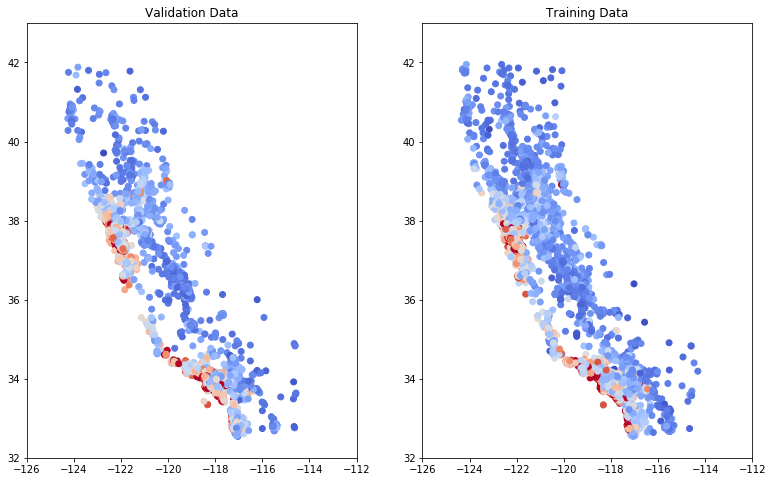

In [34]:
plt.figure(figsize=(13,8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Validation Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])

plt.scatter(validation_examples["longitude"],
           validation_examples["latitude"],
           cmap="coolwarm",
           c=validation_targets["median_house_value"]/ validation_targets["median_house_value"].max())

ax = plt.subplot(1,2,2)
ax.set_title("Training Data")
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])

plt.scatter(training_examples["longitude"],
           training_examples["latitude"],
           cmap="coolwarm",
           c=training_targets["median_house_value"]/ training_targets["median_house_value"].max())

_ = plt.plot()


Note on the above: nice trick to just plot Geostuff without an acutal map.

**Both of the above should give us a map of california, but they do not** We need to check the distribution of data in training, validation set. Yeah, the geo distribution of the data in training & validation set is totally different. For example, our training set has following:


In [16]:
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,34.6,-118.5,27.5,2655.7,547.1,1476.0,505.4,3.8,1.9
std,1.6,1.2,12.1,2258.1,434.3,1174.3,391.7,1.9,1.3
min,32.5,-121.4,1.0,2.0,2.0,3.0,2.0,0.5,0.0
25%,33.8,-118.9,17.0,1451.8,299.0,815.0,283.0,2.5,1.4
50%,34.0,-118.2,28.0,2113.5,438.0,1207.0,411.0,3.5,1.9
75%,34.4,-117.8,36.0,3146.0,653.0,1777.0,606.0,4.6,2.3
max,41.8,-114.3,52.0,37937.0,5471.0,35682.0,5189.0,15.0,55.2


And now the validation set:

In [17]:
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,38.1,-122.2,31.3,2614.8,521.1,1318.1,491.2,4.1,2.1
std,0.9,0.5,13.4,1979.6,388.5,1073.7,366.5,2.0,0.6
min,36.1,-124.3,1.0,8.0,1.0,8.0,1.0,0.5,0.1
25%,37.5,-122.4,20.0,1481.0,292.0,731.0,278.0,2.7,1.7
50%,37.8,-122.1,31.0,2164.0,424.0,1074.0,403.0,3.7,2.1
75%,38.4,-121.9,42.0,3161.2,635.0,1590.2,603.0,5.1,2.4
max,42.0,-121.4,52.0,32627.0,6445.0,28566.0,6082.0,15.0,18.3


So training set, 75% of lat is at 34.4, while in validation it is 38. Longitude: training set: -117.8, validation is -121.9

This brings us to one of the key takeaways: 

**Debugging in ML is often data *debugging* rather than code debugging**

## Task 4: Train and evalute the model

Next, lets train a linear regressor using tall the features in the data set, and see how well we do.

Lets define same input function we've used previously for loading the data into a TensorFlow model.



In [43]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linaer regression model of multiple features
    
    Args
        features: pandas DataFrame of features
        targets: pandas DataFrame of targets
        batch_size: Size of batches to be passed to the model
        shuffle: True or False. Wether to shuffle the data.
        num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    """
    
    # Conver pandas data into dicto of np arrays
    features = {key:np.array(value) for key, value in dict(features).items()}
    
    # Construct a dataset, and configure batching/repeating.
    
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds.shuffle(10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    
    return features, labels


Because we're now working with multiple input features, let's modularize our code for configuring feature columns into a sepaate function.

In [39]:
def construct_feature_columns(input_features):
    """Construct the TensorFlow Feature Columns.
    
    Args:
        input_features: The names of the numerical input features to use.
    Returns:
        A set of feature columns
    """
    
    return set([tf.feature_column.numeric_column(my_feature) 
                for my_feature in input_features])

Next, lets go ahead and complete train_model code below

In [63]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    """Trains a linear regresion model of multiple features.
    
    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.
    
    Args:
        learning_rate: A float, the learning rate
        steps: A non-zero int, the total number of training steps. A training step 
            consists of a forward and backward pass using a single batch.
        batch_size: A non-zero int, the batch size
        training_examples: A DataFrame containing one or more columns from 
            california_housing_dataframe to use as input features for training.
        training_targets: A DataFrame containing exactly one target from 
            california_housing_dataframe to use as target feature for training.
        validation_examples: A DataFrame containing one or more columns from 
            california_housing_dataframe to use as input features for validation.
        validation_targets: A DataFrame containing exactly one target from 
            california_housing_dataframe to use as target feature for validation.
            
    Returns:
        A LinearRegressor object trained on the training data.
    """
    
    periods = 10
    steps_per_period = steps / periods
    
    
    # Create linear regressor object.
    # Below is again modified from a lesson to use new version of TensorFlow
    my_optimizer = partial(optimizers.SGD, lr=learning_rate, clipvalue=0.5)


    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=construct_feature_columns(training_examples),
        optimizer=my_optimizer
    )
    
    # 1. Create input functions
    training_input_fn = lambda:my_input_fn(
        training_examples, 
        training_targets["median_house_value"], 
        batch_size=batch_size)    
    predict_training_input_fn = lambda:my_input_fn(
        training_examples, 
        training_targets["median_house_value"],
        num_epochs = 1, 
        shuffle = False)
    predict_validation_input_fn = lambda:my_input_fn(
        validation_examples, 
        validation_targets["median_house_value"],
        num_epochs = 1,
        shuffle = False)
    
    # Train the model, but do so inside a loop so that we can preiodically asses
    # loss metrics
    
    print("Training model...")
    print("RMSE (on training data:)")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
        # Train the model, starting from prior state.
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period,
        )
        # 2. Take a break and compute predictions
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        # Compute training and validation loss
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets))
        
        # Ocasionally print the current loss
        print("   period: %02d : %0.2f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
        
    print("Model training finished.")
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root MEan Squared Error vs Periods")
    plt.plot(training_rmse, label="Training")
    plt.plot(validation_rmse, label="Validation")
    plt.legend
    
    return linear_regressor
    
    

Training model...
RMSE (on training data:)
   period: 00 : 215.79
   period: 01 : 196.24
   period: 02 : 180.68
   period: 03 : 170.23
   period: 04 : 165.84
   period: 05 : 165.31
   period: 06 : 164.81
   period: 07 : 164.29
   period: 08 : 163.79
   period: 09 : 163.27
Model training finished.


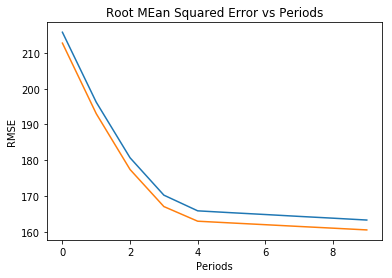

In [62]:
linear_regrossor = train_model(
    learning_rate=0.001,
    steps=100,
    batch_size=1000,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets
)

Lets validate on the test data


In [68]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

test_examples=preprocess_features(california_housing_test_data)
test_targets=preprocess_targets(california_housing_test_data)

predict_test_input_fn = lambda:my_input_fn(
    test_examples, 
    test_targets["median_house_value"],
    num_epochs = 1, 
    shuffle = False)

test_predictions = linear_regrossor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item["predictions"][0] for item in test_predictions])

test_proot_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("MSQE on test data: %0.2f" % (test_proot_mean_squared_error))


MSQE on test data: 156.52


YES! The error rate on test data is in line on the error in validation data. Happy days bro.